# Machine Learning with Scikit-Learn: Airline Ticket Price Prediction

In [1]:
# Importing a library for mathematical operations.

import numpy as np

# Importing a library for data manipulation.

import pandas as pd

# Importing libraries for data visualization.

import matplotlib.pyplot as plt
import seaborn as sns

# Importing libraries for machine learning.

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

# Importing a library for warning filtration.

from warnings import filterwarnings
filterwarnings("ignore")

## Data Collection

In [2]:
# Reading data into a Pandas DataFrame.

data = pd.read_excel("Data.xlsx")

In [3]:
# Printing first five rows of data.

data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


## Data Cleaning

In [4]:
# Printing number of missing values in each column.

data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [5]:
# Dropping rows with missing values.

data.dropna(inplace=True)

## Data Preprocessing

In [6]:
# Printing columns.

data.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

In [7]:
# Printing datatype of each column.

data.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

In [8]:
# Converting Date_of_Journey, Dep_Time and Arrival_Time columns into datetime64[ns] datatype.

for column in ["Date_of_Journey", "Dep_Time", "Arrival_Time"]:
    
    data[column] = pd.to_datetime(data[column])

In [9]:
# Adding columns for journey day and journey month.

data["Journey_Day"] = data["Date_of_Journey"].dt.day
data["Journey_Month"] = data["Date_of_Journey"].dt.month

In [10]:
# Adding columns for departure hour and departure minute.

data["Dep_Hour"] = data["Dep_Time"].dt.hour
data["Dep_Minute"] = data["Dep_Time"].dt.minute

In [11]:
# Adding columns for arrival hour and arrival minute.

data["Arrival_Hour"] = data["Arrival_Time"].dt.hour
data["Arrival_Minute"] = data["Arrival_Time"].dt.minute

In [12]:
# Defining a function to preprocess Duration column.

def preprocess_duration(duration):
    
    if "h" not in duration:
        
        duration = "0h" + " " + duration
    
    elif "m" not in duration:
        
        duration = duration + " " + "0m"
    
    return duration

In [13]:
# Preprocessing Duration column.

data["Duration"] = data["Duration"].apply(preprocess_duration)

In [14]:
# Adding columns for duration hour and duration minute.

data["Duration_Hour"] = data["Duration"].apply(lambda duration: int(duration.split(" ")[0][0:-1]))
data["Duration_Minute"] = data["Duration"].apply(lambda duration: int(duration.split(" ")[1][0:-1]))

In [15]:
# Adding a column for total duration in minutes.

data["Total_Duration_Minute"] = data["Duration_Hour"] * 60 + data["Duration_Minute"]

In [16]:
# Dropping Date_of_Journey, Dep_Time, Arrival_Time and Duration columns.

for column in ["Date_of_Journey", "Dep_Time", "Arrival_Time", "Duration"]:
    
    data.drop(column, axis=1, inplace=True)

In [17]:
# Printing first five rows of data.

data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Duration_Hour,Duration_Minute,Total_Duration_Minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50,170
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25,445
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0,1140
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25,325
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45,285


## Data Analysis

### Analysis 1:

Analyzing the number of flight departures at various time intervals.

In [18]:
# Defining a function to find time intervals.

def find_time_intervals(hour):
    
    if hour > 4 and hour <= 8:
        
        return "Early Morning"
    
    elif hour > 8 and hour < 12:
        
        return "Morning"
    
    elif hour == 12:
        
        return "Noon"
    
    elif hour > 12 and hour <= 16:
        
        return "Afternoon"
    
    elif hour > 16 and hour <= 20:
        
        return "Evening"
    
    elif hour > 20 and hour <= 24:
        
        return "Night"
    
    else:
        
        return "Late Night"

In [19]:
# Printing number of flights departing at various time intervals.

data["Dep_Hour"].apply(find_time_intervals).value_counts()

Dep_Hour
Early Morning    2880
Evening          2357
Morning          2031
Afternoon        1731
Night            1040
Late Night        465
Noon              178
Name: count, dtype: int64

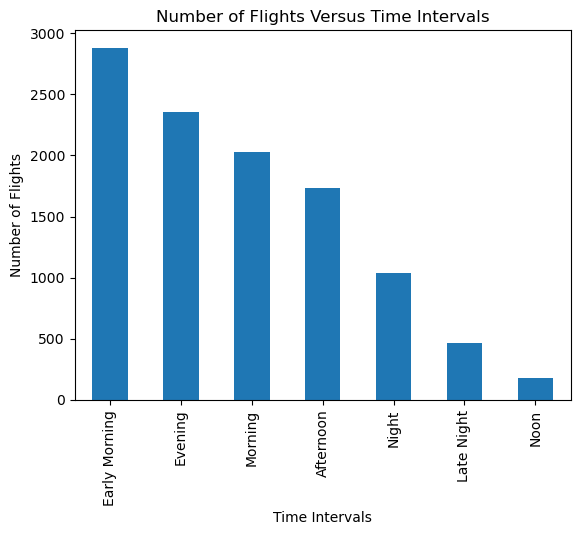

In [20]:
# Plotting a bar plot for number of flights versus time intervals.

data["Dep_Hour"].apply(find_time_intervals).value_counts().plot(kind="bar")
plt.title("Number of Flights Versus Time Intervals")
plt.xlabel("Time Intervals")
plt.ylabel("Number of Flights")
plt.show()

### Conclusion 1:

Early morning has the highest number of flight departures while noon has the lowest number of flight departures.

### Analysis 2:

Analyzing the correlation among ticket prices, journey durations and total stops.

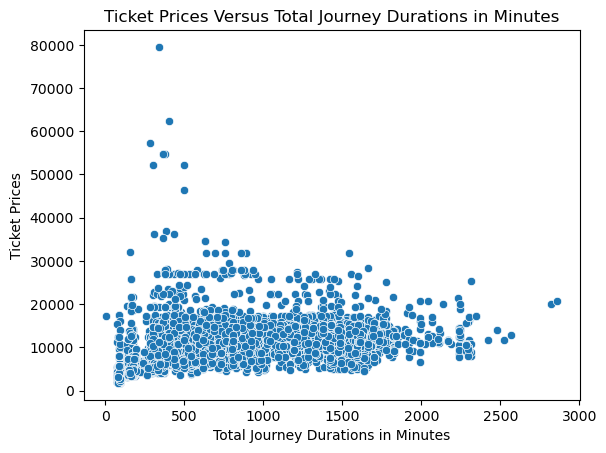

In [21]:
# Plotting a scatter plot for ticket prices versus total journey durations in minutes.

sns.scatterplot(data, x="Total_Duration_Minute", y="Price")
plt.title("Ticket Prices Versus Total Journey Durations in Minutes")
plt.xlabel("Total Journey Durations in Minutes")
plt.ylabel("Ticket Prices")
plt.show()

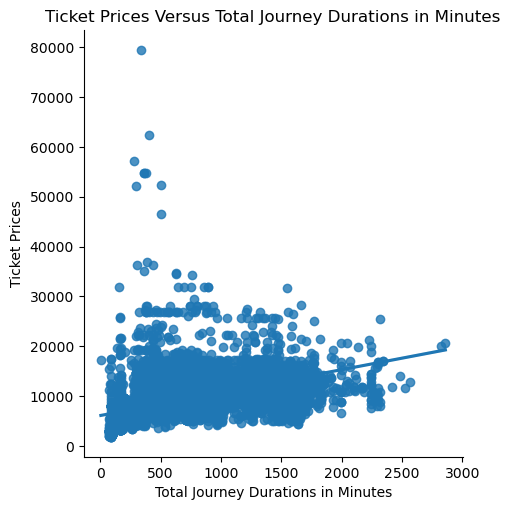

In [22]:
# Plotting a linear regression plot for ticket prices versus total journey durations in minutes.

sns.lmplot(data, x="Total_Duration_Minute", y="Price")
plt.title("Ticket Prices Versus Total Journey Durations in Minutes")
plt.xlabel("Total Journey Durations in Minutes")
plt.ylabel("Ticket Prices")
plt.show()

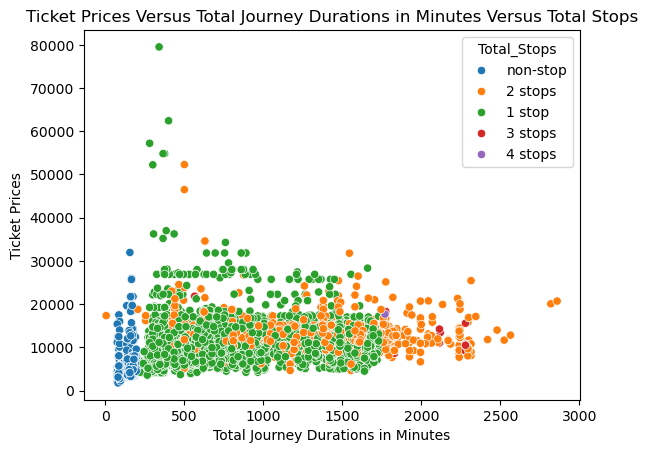

In [23]:
# Plotting a scatter plot for ticket prices versus total journey durations in minutes versus total stops.

sns.scatterplot(data, x="Total_Duration_Minute", y="Price", hue="Total_Stops")
plt.title("Ticket Prices Versus Total Journey Durations in Minutes Versus Total Stops")
plt.xlabel("Total Journey Durations in Minutes")
plt.ylabel("Ticket Prices")
plt.show()

### Conclusion 2:

Ticket prices do not significantly correlate to journey durations and total stops. However, journey durations increase as total stops increase.

### Analysis 3:

Analyzing the distribution of ticket prices for various airlines.

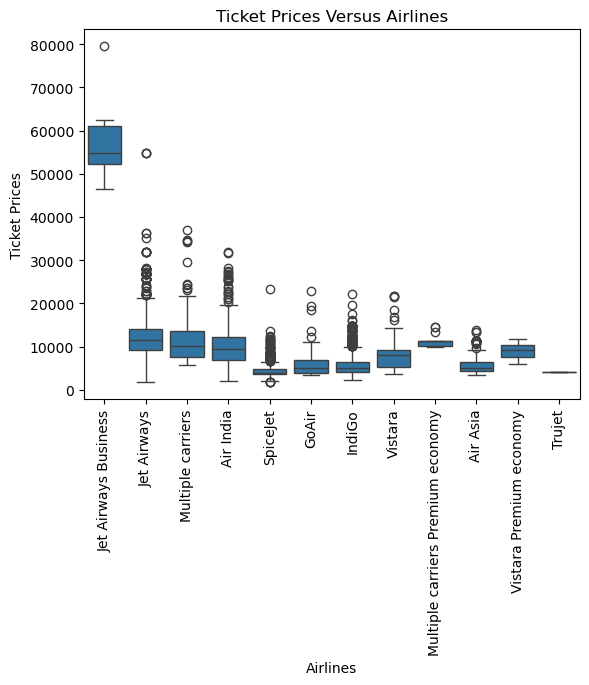

In [24]:
# Plotting a box plot for ticket prices versus airlines.

sns.boxplot(data.sort_values("Price", ascending=False), x="Airline", y="Price")
plt.title("Ticket Prices Versus Airlines")
plt.xlabel("Airlines")
plt.ylabel("Ticket Prices")
plt.xticks(rotation="vertical")
plt.show()

### Conclusion 3:

Jet Airways Business has the highest distribution of ticket prices while Trujet has the lowest distribution of ticket prices.

### Analysis 4:

Analyzing the number of flights on each route for Jet Airways.

In [25]:
# Printing number of flights on each route for Jet Airways.

data[data["Airline"] == "Jet Airways"].groupby("Route").size().sort_values(ascending=False)

Route
CCU → BOM → BLR          930
DEL → BOM → COK          875
BLR → BOM → DEL          385
BLR → DEL                382
CCU → DEL → BLR          300
BOM → HYD                207
DEL → JAI → BOM → COK    207
DEL → AMD → BOM → COK    141
DEL → IDR → BOM → COK     86
DEL → NAG → BOM → COK     61
DEL → ATQ → BOM → COK     38
DEL → COK                 34
DEL → BHO → BOM → COK     29
DEL → BDQ → BOM → COK     28
DEL → LKO → BOM → COK     25
DEL → JDH → BOM → COK     23
CCU → GAU → BLR           22
DEL → MAA → BOM → COK     16
DEL → IXC → BOM → COK     13
BLR → MAA → DEL           10
BLR → BDQ → DEL            8
DEL → UDR → BOM → COK      7
BOM → DEL → HYD            5
CCU → BOM → PNQ → BLR      4
BLR → BOM → JDH → DEL      3
DEL → DED → BOM → COK      2
BOM → BDQ → DEL → HYD      2
DEL → CCU → BOM → COK      1
BOM → VNS → DEL → HYD      1
BOM → UDR → DEL → HYD      1
BOM → JDH → DEL → HYD      1
BOM → IDR → DEL → HYD      1
BOM → DED → DEL → HYD      1
dtype: int64

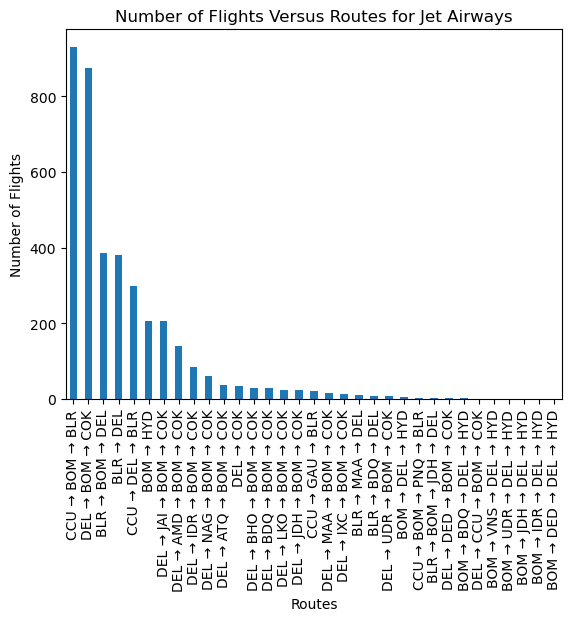

In [26]:
# Plotting a bar plot for number of flights versus routes for Jet Airways.

data[data["Airline"] == "Jet Airways"].groupby("Route").size().sort_values(ascending=False).plot(kind="bar")
plt.title("Number of Flights Versus Routes for Jet Airways")
plt.xlabel("Routes")
plt.ylabel("Number of Flights")
plt.show()

### Conclusion 4:

Jet Airways has the highest number of flights on the route:
- CCU → BOM → BLR

Jet Airways has the lowest number of flights on the routes:
- DEL → CCU → BOM → COK
- BOM → VNS → DEL → HYD
- BOM → UDR → DEL → HYD
- BOM → JDH → DEL → HYD
- BOM → IDR → DEL → HYD
- BOM → DED → DEL → HYD

## Feature Encoding

In [27]:
# Printing categorical columns.

[column for column in data.columns if data[column].dtype == "object"]

['Airline', 'Source', 'Destination', 'Route', 'Total_Stops', 'Additional_Info']

In [28]:
# Printing numerical columns.

[column for column in data.columns if data[column].dtype != "object"]

['Price',
 'Journey_Day',
 'Journey_Month',
 'Dep_Hour',
 'Dep_Minute',
 'Arrival_Hour',
 'Arrival_Minute',
 'Duration_Hour',
 'Duration_Minute',
 'Total_Duration_Minute']

In [29]:
# Printing unique items in Airline column.

data["Airline"].unique()

array(['IndiGo', 'Air India', 'Jet Airways', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia',
       'Vistara Premium economy', 'Jet Airways Business',
       'Multiple carriers Premium economy', 'Trujet'], dtype=object)

In [30]:
# Performing target guided encoding on Airline column.

# Sorting airlines in ascending order based on mean price.

airlines = data.groupby("Airline")["Price"].mean().sort_values().index
print(airlines)

# Enumerating airlines based on mean price.

airlines_enumerate = {key: value for value, key in enumerate(airlines)}
print("\n")
print(airlines_enumerate)

# Mapping enumerated airlines to Airline column.

data["Airline"] = data["Airline"].map(airlines_enumerate)

Index(['Trujet', 'SpiceJet', 'Air Asia', 'IndiGo', 'GoAir', 'Vistara',
       'Vistara Premium economy', 'Air India', 'Multiple carriers',
       'Multiple carriers Premium economy', 'Jet Airways',
       'Jet Airways Business'],
      dtype='object', name='Airline')


{'Trujet': 0, 'SpiceJet': 1, 'Air Asia': 2, 'IndiGo': 3, 'GoAir': 4, 'Vistara': 5, 'Vistara Premium economy': 6, 'Air India': 7, 'Multiple carriers': 8, 'Multiple carriers Premium economy': 9, 'Jet Airways': 10, 'Jet Airways Business': 11}


In [31]:
# Printing unique items in Source column.

data["Source"].unique()

array(['Banglore', 'Kolkata', 'Delhi', 'Chennai', 'Mumbai'], dtype=object)

In [32]:
# Performing one-hot encoding on Source column.

for source in data["Source"].unique():
    
    # Adding indivisual columns for various sources.
    
    data["Source_" + source] = data["Source"].apply(lambda location: 1 if location == source else 0)

In [33]:
# Printing unique items in Destination column.

data["Destination"].unique()

array(['New Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Delhi', 'Hyderabad'],
      dtype=object)

In [34]:
# Replacing New Delhi with Delhi in Destination column.

data["Destination"].replace("New Delhi", "Delhi", inplace=True)

In [35]:
# Performing target guided encoding on Destination column.

# Sorting destinations in ascending order based on mean price.

destinations = data.groupby("Destination")["Price"].mean().sort_values().index
print(destinations)

# Enumerating destinations based on mean price.

destinations_enumerate = {key: value for value, key in enumerate(destinations)}
print("\n")
print(destinations_enumerate)

# Mapping enumerated destinations to Destination column.

data["Destination"] = data["Destination"].map(destinations_enumerate)

Index(['Kolkata', 'Hyderabad', 'Delhi', 'Banglore', 'Cochin'], dtype='object', name='Destination')


{'Kolkata': 0, 'Hyderabad': 1, 'Delhi': 2, 'Banglore': 3, 'Cochin': 4}


In [36]:
# Printing unique items in Total_Stops column.

data["Total_Stops"].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [37]:
# Performing manual label encoding on Total_Stops column.

# Enumerating total stops based on number of stops.

total_stops_enumerate = {"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}
print(total_stops_enumerate)

# Mapping enumerated total stops to Total_Stops column.

data["Total_Stops"] = data["Total_Stops"].map(total_stops_enumerate)

{'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4}


In [38]:
# Dropping Source, Route and Additional_Info columns.

for column in ["Source", "Route", "Additional_Info"]:
    
    data.drop(column, axis=1, inplace=True)

In [39]:
# Printing first five rows of data.

data.head()

,Airline,Destination,Total_Stops,Price,Journey_Day,Journey_Month,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Duration_Hour,Duration_Minute,Total_Duration_Minute,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,3,2,0,3897,24,3,22,20,1,10,2,50,170,1,0,0,0,0
1,7,3,2,7662,1,5,5,50,13,15,7,25,445,0,1,0,0,0
2,10,4,2,13882,9,6,9,25,4,25,19,0,1140,0,0,1,0,0
3,3,3,1,6218,12,5,18,5,23,30,5,25,325,0,1,0,0,0
4,3,2,1,13302,1,3,16,50,21,35,4,45,285,1,0,0,0,0


## Outlier Detection

In [40]:
# Defining a function to plot variation.

def plot_variation(column):
    
    # Plotting a plot with three rows and one column.
    
    figure, (axis1, axis2, axis3) = plt.subplots(3, 1)
    
    # Plotting a distribution plot, a histogram and a box plot as subplots.
    
    sns.distplot(x=column, ax=axis1)
    sns.distplot(x=column, ax=axis2, kde=False)
    sns.boxplot(x=column, ax=axis3)

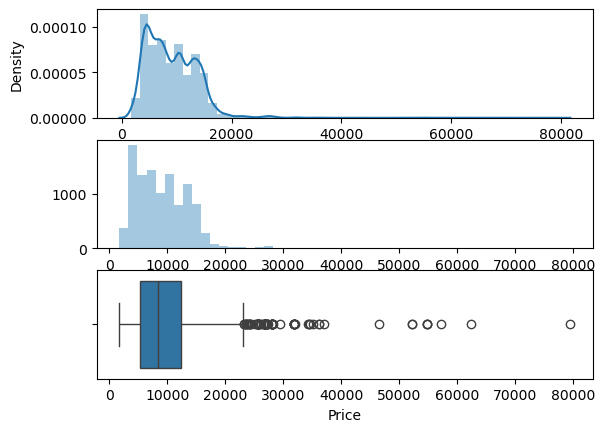

In [41]:
# Plotting variation in Price column.

plot_variation(data["Price"])

In [42]:
# Defining a function to calculate upper and lower bounds for outliers.

def outlier_bounds(column):
    
    # Calculating first quantile, third quantile and inter quantile range.

    quantile1 = column.quantile(0.25)
    quantile3 = column.quantile(0.75)
    inter_quantile_range = quantile3 - quantile1

    # Calculating upper and lower bounds for outliers.

    upper = quantile3 + 1.5 * inter_quantile_range
    lower = quantile1 - 1.5 * inter_quantile_range
    
    return upper, lower

In [43]:
# Calculating upper and lower bounds for outliers in Price column.

upper, lower = outlier_bounds(data["Price"])

In [44]:
# Printing number of outliers in Price column.

len([price for price in data["Price"] if price > upper or price < lower])

94

In [45]:
# Replacing outliers with median in Price column.

data["Price"] = np.where(data["Price"] >= 35000, data["Price"].median(), data["Price"])

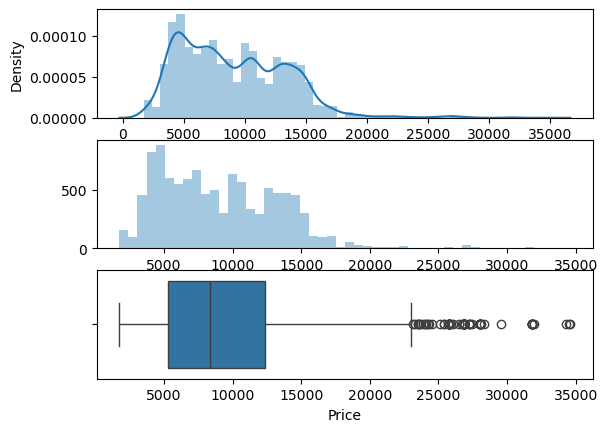

In [46]:
# Plotting variation in Price column.

plot_variation(data["Price"])

## Feature Selection

In [47]:
# Assigning feature matrix.

X = data.drop("Price", axis=1)

# Assigning target vector.

y = data["Price"]

In [48]:
# Estimating mutual information.

information = mutual_info_regression(X, y)

In [49]:
# Assigning mutual information into a Pandas DataFrame.

mutual_information = pd.DataFrame(information, index=X.columns)
mutual_information.columns = ["Mutual_Information"]
mutual_information.sort_values("Mutual_Information", ascending=False, inplace=True)

# Printing mutual information.

mutual_information

,Mutual_Information
Total_Duration_Minute,1.769158
Airline,1.326155
Arrival_Hour,1.135329
Duration_Hour,1.125162
Destination,1.070180
Dep_Hour,0.926913
Arrival_Minute,0.898723
Total_Stops,0.792248
Dep_Minute,0.767196
Duration_Minute,0.678881


## Machine Learning

In [50]:
# Splitting data into random train and test subsets.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [51]:
# Building a random forest regressor model.

model = RandomForestRegressor()

# Fitting model on training set.

model.fit(X_train, y_train)

RandomForestRegressor()

In [52]:
# Predicting regression target for testing set.

y_prediction = model.predict(X_test)
y_prediction

array([16735.07      ,  5326.27      ,  8939.3       , ...,
        6823.085     ,  9212.11      , 12003.25833333])

In [53]:
# Assigning predictions into a Pandas DataFrame.

predictions = pd.DataFrame(y_prediction)
predictions.columns = ["Ticket Price Predictions"]
predictions.set_index("Ticket Price Predictions", inplace=True)

# Printing predictions.

predictions

""
Ticket Price Predictions
16735.070000
5326.270000
8939.300000
3729.790000
15120.637500
...
10875.070000
15236.807667
6823.085000


## Machine Learning Pipeline Automation

In [54]:
# Defining a function to evaluate model.

def evaluate_model(model):
    
    # Fitting model on training set.
    
    model = model.fit(X_train, y_train)
    
    # Predicting regression target for testing set.
    
    y_prediction = model.predict(X_test)
    
    # Printing predictions.
    
    print("Predictions: ", y_prediction)
    
    # Printing coefficient of determination of prediction.
    
    print("Accuracy Score: ", model.score(X_test, y_test))
    
    # Printing R^2 regression score.
    
    print("R^2 Score: ", r2_score(y_test, y_prediction))
    
    # Printing mean absolute error, mean absolute percentage error, mean squared error and root mean squared error.
    
    print("Mean Absolute Error: ", mean_absolute_error(y_test, y_prediction))
    print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(y_test, y_prediction))
    print("Mean Squared Error: ", mean_squared_error(y_test, y_prediction))
    print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_test, y_prediction)))
    
    # Plotting a distribution plot for actual versus predicted values.
    
    sns.distplot(y_test - y_prediction)
    plt.title(f"Actual Versus Predicted Values for {model}")

Predictions:  [16782.72        5471.18        8960.25       ...  6816.02
  9094.22       12024.01166667]
Accuracy Score:  0.8218101873284626
R^2 Score:  0.8218101873284626
Mean Absolute Error:  1162.0108589899576
Mean Absolute Percentage Error:  0.13150056686992687
Mean Squared Error:  3421907.3163717138
Root Mean Squared Error:  1849.83980830009


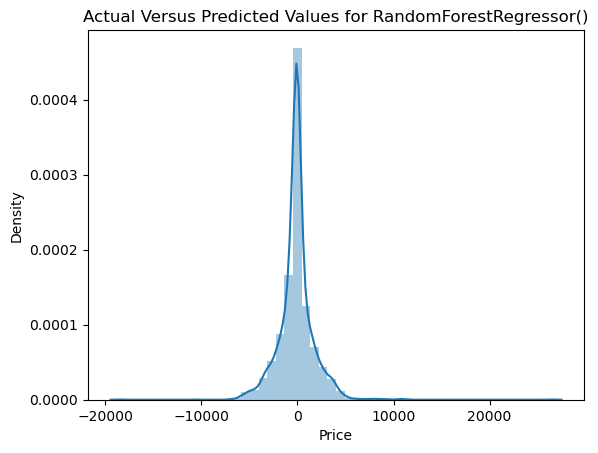

In [55]:
# Evaluating a random forest regressor model.

evaluate_model(RandomForestRegressor())

Predictions:  [16743.75  5206.32  9085.18 ...  6969.04  9580.87 12393.52]
Accuracy Score:  0.7928566743780741
R^2 Score:  0.7928566743780741
Mean Absolute Error:  1199.220214596332
Mean Absolute Percentage Error:  0.13484743077707856
Mean Squared Error:  3977922.4797201823
Root Mean Squared Error:  1994.4729829506798


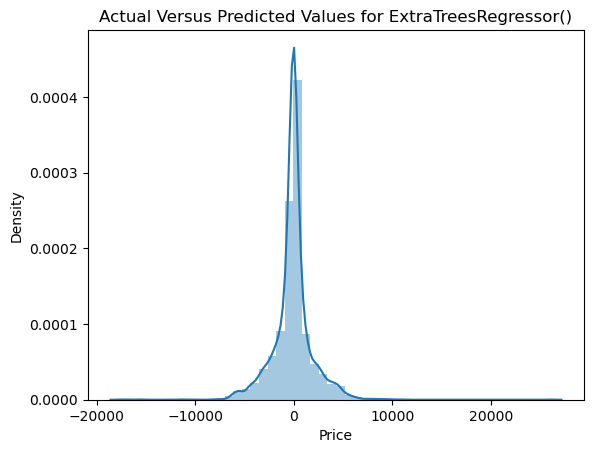

In [56]:
# Evaluating an extra trees regressor model.

evaluate_model(ExtraTreesRegressor())

Predictions:  [16840.   6976.   8610.  ...  5118.  10208.  11652.5]
Accuracy Score:  0.7242793503340714
R^2 Score:  0.7242793503340714
Mean Absolute Error:  1354.5085365853658
Mean Absolute Percentage Error:  0.15253840149900472
Mean Squared Error:  5294862.227089084
Root Mean Squared Error:  2301.0567631175645


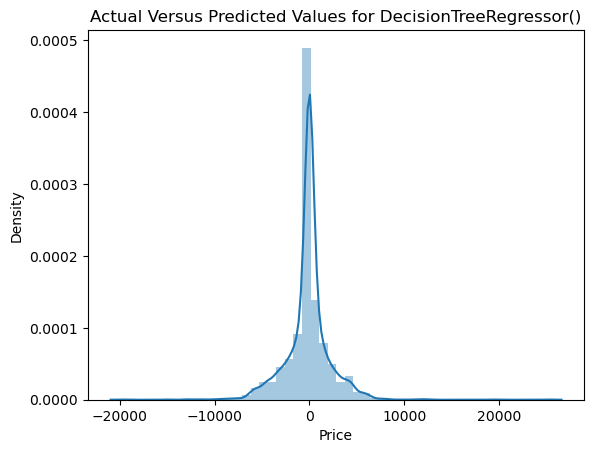

In [57]:
# Evaluating a decision tree regressor model.

evaluate_model(DecisionTreeRegressor())

## Machine Learning Hypertuning

In [58]:
# Assigning hyper parameters for a random forest regressor model.

hyper_parameters = {"n_estimators": [int(number) for number in np.linspace(start=100, stop=1000, num=6)],
                    "max_depth": [int(number) for number in np.linspace(start=5, stop=25, num=5)],
                    "min_samples_split": [5, 10, 15],
                    "max_features": ["auto", "sqrt", "log2"]}

In [59]:
# Building a randomized search on hyper parameters for a random forest regressor model.

randamized_search = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=hyper_parameters, n_jobs=-1,
                                       verbose=2)

# Fitting randamized search on training set.

randamized_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_split': [5, 10, 15],
                                        'n_estimators': [100, 280, 460, 640,
                                                         820, 1000]},
                   verbose=2)

In [60]:
# Calculating best parameters for model.

best_parameters = randamized_search.best_params_
best_parameters

{'n_estimators': 280,
 'min_samples_split': 5,
 'max_features': 'sqrt',
 'max_depth': 20}

In [61]:
# Printing best score for model.

randamized_search.best_score_

0.8016929679306747

## Machine Learning on Hyper Parameters

In [62]:
# Building a random forest regressor model on hyper parameters.

model = RandomForestRegressor(n_estimators=best_parameters["n_estimators"],
                              max_depth=best_parameters["max_depth"],
                              min_samples_split=best_parameters["min_samples_split"],
                              max_features=best_parameters["max_features"])

# Fitting model on training set.

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_split=5,
                      n_estimators=280)

In [63]:
# Predicting regression target for testing set.

y_prediction = model.predict(X_test)
y_prediction

array([16396.52252693,  5458.27141675,  8648.50896962, ...,
        8360.32321287,  8974.06047696, 11777.88029506])

In [64]:
# Assigning predictions into a Pandas DataFrame.

predictions = pd.DataFrame(y_prediction)
predictions.columns = ["Ticket Price Predictions"]
predictions.set_index("Ticket Price Predictions", inplace=True)

# Printing predictions.

predictions

""
Ticket Price Predictions
16396.522527
5458.271417
8648.508970
3703.361671
14160.538844
...
11190.883123
14753.631491
8360.323213


Predictions:  [16463.91469813  5443.96541435  8577.76339114 ...  8350.73284091
  8973.36768991 11735.71053966]
Accuracy Score:  0.8225929726722734
R^2 Score:  0.8225929726722734
Mean Absolute Error:  1214.844564681392
Mean Absolute Percentage Error:  0.13841089544898802
Mean Squared Error:  3406874.9256027066
Root Mean Squared Error:  1845.7721759747888


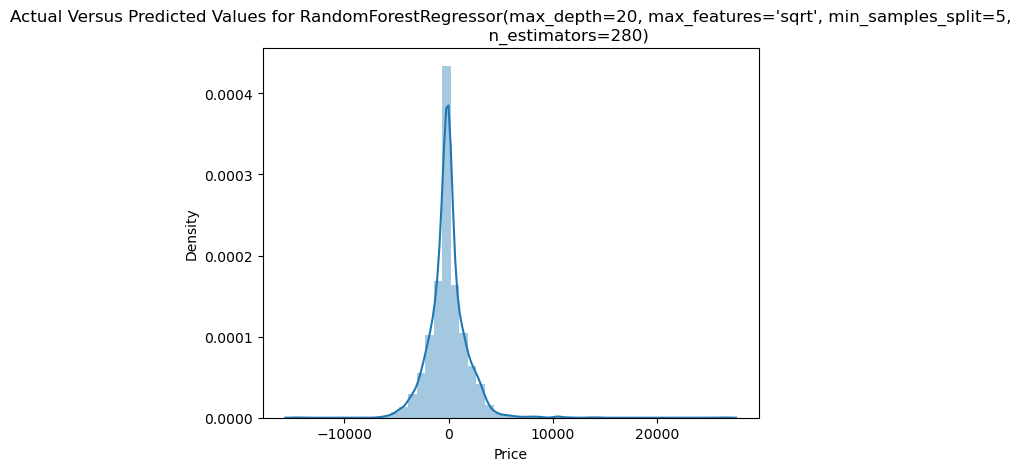

In [65]:
# Evaluating a random forest regressor model built on hyper parameters.

evaluate_model(model)